# Reinforcement Learning Tarea 3 - Métodos Monte Carlo (blackjack)

En este laboratorio vamos a explorar los métodos de Monte Carlo (Capítulo 5 del libro de Sutton y Barto). Para esto, vamos a volver a utilizar un ambiente definido en [Gymnasium](https://gymnasium.farama.org/index.html), es el caso esta vez de otro ambiente sencillo: el juego de Blackjack. El [ambiente de gymnasium](https://gymnasium.farama.org/environments/toy_text/blackjack/) esta inspirado por el ejemplo 5.1 del libro, ya esta incluido en gym, por lo que no es necesario crearlo desde cero. 


## Descripción del ambiente a usar

### Reglas del juego

Es un juego de cartas donde el objetivo es obtener cartas que sumen lo más cercano a 21 posible, sin pasarnos. Jugamos contra un dealer fijo unicamente.

Reglas:
   
- Las cartas con figuras (Jotas, Reinas y Reyes) tienen valor de 10.
- Los Ases pueden valer 11 ó 1, cuando vale 11 se lo llama "usable" y es su valor por defecto.
- En este caso jugamos con un mazo infinito (con reemplazo).
- El dealer comienza con una carta boca arriba y una boca abajo.
- El jugador puede pedir una carta (HIT) hasta que decida quedarse (STICK) o exceeda los 21 puntos (BUST).
- Cuando el jugador se queda (STICK), el dealer muestra su carta boca abajo y pide cartas hasta que su suma sea 17 o más.
- Si el dealer se pasa de 21, el jugador gana. En caso contrario, gana quien tenga la suma más cerca de 21.

### Implementación en Gymnasium

- La reward por perder es -1, por ganar es +1 y por pedir carta es 0. En caso de empate, la reward es 0.
- Cada observacion es una tupla que tiene: 
    - la suma del jugador
    - la carta boca arriba del dealer (1-10 donde 1 es un As)
    - True o False si el jugador tiene un As usable o no

Revisa el [ambiente en gymnasium](https://gymnasium.farama.org/environments/toy_text/blackjack/) para entender como funciona.


### A entregar

- Notebook con solución a los algoritmos presentados
- Analisis de la función de valor estimada para distinto número de episodios a visitar (ej: 100, 10000, 50000, 500000). Se busca que puedan demostrar entendimiento del algoritmo y sus resultados (Esperamos gráficas y analisis de las mismas). 
- Estimaciones de función de valor para otras politicas definidas por el estudiante (al menos una). 

In [1]:
import gymnasium as gym
from gymnasium.utils.play import play
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from Utils import plot_value_distribution, plot_Q_distribution

In [2]:
# Nos asegurams que las gráficas se muestren en el notebook
import matplotlib
%matplotlib inline

 Vemos el espacio de estado y acción del ambiente de blackjack.

In [3]:
# Crear el entorno de Blackjack
env = gym.make("Blackjack-v1", render_mode="rgb_array")
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [4]:
# vemos un ejemplo de observación
obs, _ = env.reset()
print(f"Jugador: {obs[0]}, Dealer: {obs[1]}, As usable: {obs[2]} ")

Jugador: 19, Dealer: 6, As usable: 0 


Simulemos una partida de blackjack.

In [7]:
# Caso de prueba
state,_ = env.reset()
print('initial state:', state)

while True:
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    print('state:', state, 'reward:', reward, 'done:', done)
    if done or truncated:
        print(f'Reward: {reward}')                
        break

initial state: (21, 9, 1)
state: (21, 9, 1) reward: 1.0 done: True
Reward: 1.0


## Predicción de la función de valor ($V$ y $Q$)

Vamos a implementar el algoritmo de Monte Carlo para estimar las funciones de valor $V$ y $Q$ para el ambiente de blackjack asi como algunas variantes (first visit, every visit, exploración inicial, etc).

Para ello primero vamos a definir una politica: Si suma 20 o más, se queda (STICK), si no pide carta (HIT). Esta política es la que se usa en el ejemplo del libro.

In [8]:
STICK = 0
HIT = 1
       
## Politica Sutton & Barto
def sutton_policy(observation):
    sum, _, _ = observation
    return STICK if sum >= 20 else HIT

### Generación de episodios

Vamos a implementar una función que genere episodios de la política definida. La función va a recibir el ambiente y la política y va a devolver una lista de transiciones (estado, acción, reward, next_state).

In [9]:
def generate_episode(policy, env):
    """
    Genera un episodio utilizando la política dada.
    Args:
        policy: Función que toma un estado y devuelve una acción.
        env: Entorno de OpenAI Gym.
    Returns:
        episode: Lista de tuplas (estado, acción, recompensa, siguiente_estado).
    """
    episodio = []
    state, _ = env.reset()
    done = False
    while not done:
        action = policy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episodio.append((state, action, reward, next_state))
        state = next_state
    return episodio

In [10]:
# lo probamos
episode = generate_episode(sutton_policy, env)
print("Episodio generado:")
for state, action, reward, next_state in episode:
    print(f"Estado: {state}, Acción: {action} ({'Hit' if action == 1 else 'Stick'}), Recompensa: {reward}, Siguiente estado: {next_state}")

Episodio generado:
Estado: (8, 10, 0), Acción: 1 (Hit), Recompensa: 0.0, Siguiente estado: (10, 10, 0)
Estado: (10, 10, 0), Acción: 1 (Hit), Recompensa: 0.0, Siguiente estado: (12, 10, 0)
Estado: (12, 10, 0), Acción: 1 (Hit), Recompensa: 0.0, Siguiente estado: (16, 10, 0)
Estado: (16, 10, 0), Acción: 1 (Hit), Recompensa: -1.0, Siguiente estado: (26, 10, 0)


### First-Visit MC para estimar $V$

El primer algoritmo que vamos a implementar es el de Monte Carlo First Visit. Este algoritmo estima la función de valor $V$ para una política dada.

$$
\begin{aligned}
\textbf{Algoritmo First-Visit MC (para estimar }v_\pi\text{):} \\[6pt]
\textbf{Entrada:} & \quad \pi,\ \text{política a evaluar.}\\
& \quad \text{(Se asume que podemos generar episodios con } \pi\text{.)}\\[6pt]
\textbf{Inicializar:} 
& \quad V(s) \in \mathbb{R}, \quad \forall\, s \in S \quad (\text{valores arbitrarios})\\
& \quad \text{Returns}(s) \leftarrow \varnothing, \quad \forall\, s \in S.\\[6pt]
\textbf{Bucle (por cada episodio):} 
& \\[-2pt]
& \quad \text{Generar un episodio siguiendo } \pi: (S_0, A_0, R_1, \ldots, S_T).\\
& \quad G \leftarrow 0.\\
& \quad \textbf{para } t = T-1,\, T-2,\, \ldots,\, 0:\\
& \quad\quad G \leftarrow \gamma\,G + R_{t+1}.\\
& \quad\quad \textbf{si } S_t \notin \{S_0, S_1, \ldots, S_{t-1}\}:\\
& \quad\quad\quad \text{Returns}(S_t) \leftarrow \text{Returns}(S_t) \cup \{G\}.\\
& \quad\quad\quad V(S_t) \leftarrow \text{average}\bigl(\text{Returns}(S_t)\bigr).\\[6pt]
\textbf{Retornar:} 
& \quad V.
\end{aligned}
$$

> Tip: con [defaultdict](https://docs.python.org/3/library/collections.html#defaultdict-objects) podemos definir un diccionario con un valor por defecto.

In [ ]:
A = defaultdict(float)
B = defaultdict(int)
C = defaultdict(lambda: [])

print(A[999])
print(B[999])
print(C[999])

In [11]:
def first_visit_mc_prediction(policy, env, number_episodes, gamma=1.0):
    V = defaultdict(float)
    returns = defaultdict(list)
    for _ in tqdm(range(number_episodes)):
        episode = generate_episode(policy, env)
        G = 0
        T = len(episode)
        t = T - 1
        while t >= 0:
            state, action, reward, next_state = episode[t]
            G = gamma * G + reward
            states_hasta_t = [ s for s,_,_,_ in episode[:t]]
            if state not in states_hasta_t:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
            t -= 1
    return V

In [14]:
# sab_value = first_visit_mc_prediction(sutton_policy, env, number_episodes=500_000)
sab_value = first_visit_mc_prediction(sutton_policy, env, number_episodes=50000)

100%|██████████| 50000/50000 [00:03<00:00, 13337.93it/s]


In [15]:
print(sab_value)

defaultdict(<class 'float'>, {(21, 10, 0): np.float64(0.904375), (16, 10, 0): np.float64(-0.6588921282798834), (19, 10, 0): np.float64(-0.7406380027739251), (17, 10, 0): np.float64(-0.6774505070014486), (10, 10, 0): np.float64(-0.1905424200278164), (18, 7, 0): np.float64(-0.6697936210131332), (21, 10, 1): np.float64(0.9071274298056156), (16, 4, 0): np.float64(-0.59765625), (9, 4, 0): np.float64(-0.6028368794326241), (20, 2, 1): np.float64(0.5217391304347826), (15, 2, 1): np.float64(-0.37777777777777777), (21, 7, 0): np.float64(0.9394736842105263), (11, 7, 0): np.float64(0.013761467889908258), (20, 3, 0): np.float64(0.6305483028720626), (20, 5, 0): np.float64(0.6465968586387435), (18, 5, 0): np.float64(-0.6554054054054054), (16, 5, 0): np.float64(-0.6322701688555347), (21, 5, 0): np.float64(0.8994845360824743), (17, 5, 0): np.float64(-0.697495183044316), (13, 5, 0): np.float64(-0.5942982456140351), (18, 5, 1): np.float64(-0.4864864864864865), (14, 6, 0): np.float64(-0.5682730923694779),

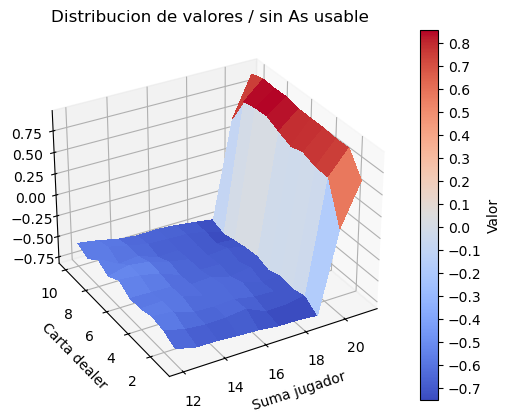

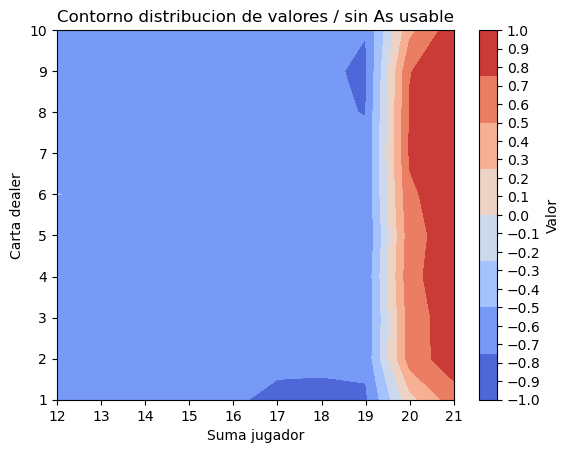

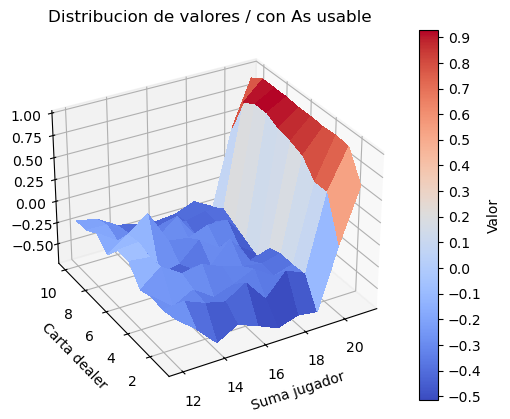

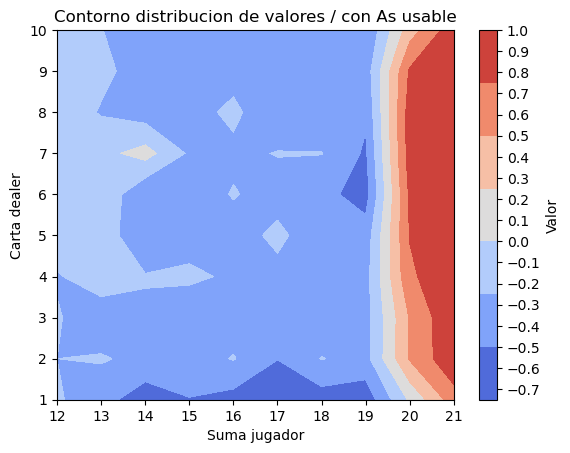

In [16]:
plot_value_distribution(sab_value)

Una estrategía más elaborada, basada en Edward Thorp, que se basa en la carta del dealer y la suma del jugador. La idea es que si el dealer tiene una carta baja (2-6) el jugador se queda si tiene 12 o más, si no pide carta. Si el dealer tiene una carta alta (7-10) el jugador se queda si tiene 17 o más, si no pide carta.

100%|██████████| 500000/500000 [02:02<00:00, 4070.63it/s]


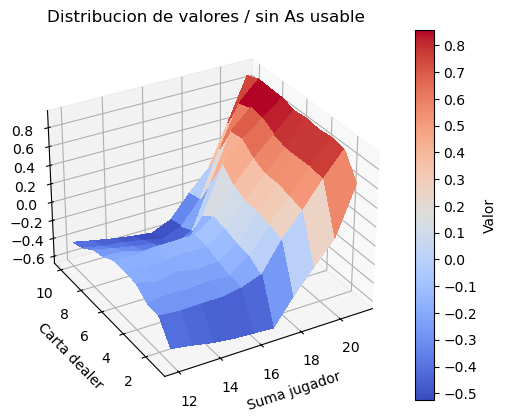

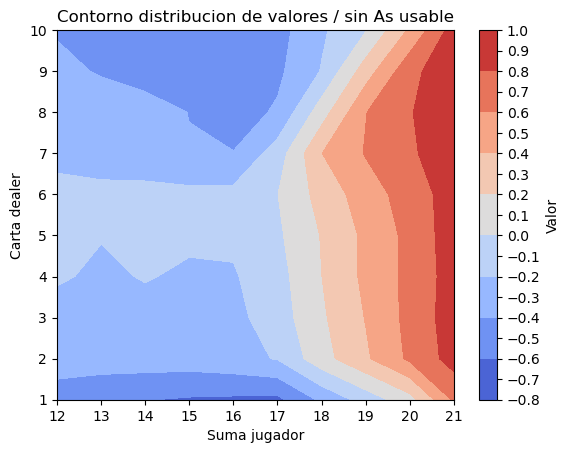

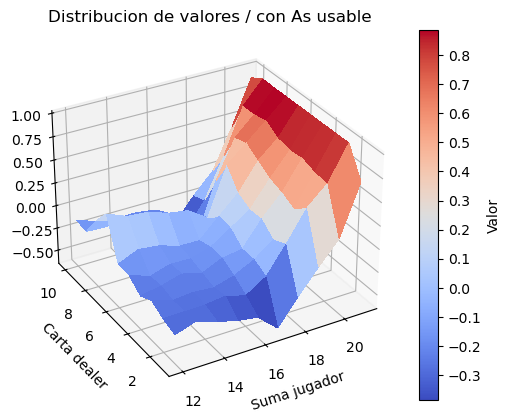

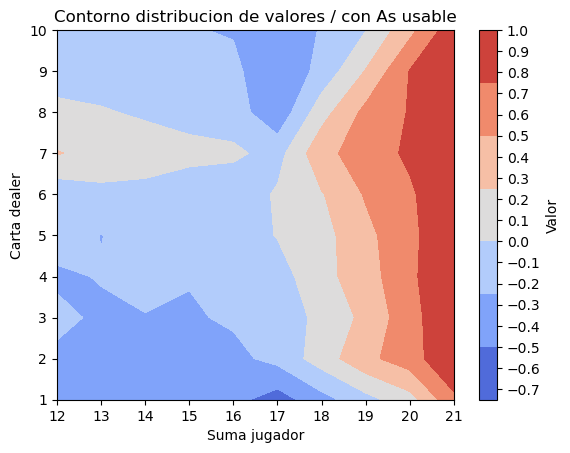

In [17]:
def thorp_policy(observation):
    player_sum, dealer_card, usable_ace = observation
    # Si la suma del jugador es menor a 12, nunca se pasa, así que se pide carta.
    if player_sum < 12:
        return HIT
    # Para sumas entre 12 y 16, se aconseja quedarse si el dealer muestra una carta débil (2 a 6),
    # ya que el dealer tiene más probabilidad de pasarse.
    if 12 <= player_sum <= 16:
        if 2 <= dealer_card <= 6:
            return STICK
        else:
            return HIT
    # Con una suma de 17 o mayor, es recomendable plantarse.
    return STICK

thorp_value = first_visit_mc_prediction(thorp_policy, env, number_episodes=500_000)

plot_value_distribution(thorp_value)

> 1) ¿Qué valores se esperan de $V$ si implementamos el algoritmo de Monte Carlo Every Visit en este caso? ¿Por qué?
> 2) Definir una política diferente que tenga en cuenta el As usable y estimar su función de valor. 

### First-Visit MC para estimar $Q$ con exploración inicial

Cuando queremos estimar la función de valor $Q$ para una política dada, tenemos el problema de que no tenemos una política exploratoria. Por ende podría no visitar todos los estados y acciones. Para resolver esto, podemos usar la técnica de exploración inicial donde se elige un estado aleatorio ($S_0$) y una acción aleatoria ($A_0$) y se juega un episodio desde ahí. Esto nos permite explorar el espacio de estados y acciones. 

> Notar que la política no cambia, solo se elige un estado y acción aleatorios para empezar a jugar.

> El desafío en Gymnasium es que no podemos elegir el estado inicial. Pero podemos intentar "hacer trampa" y modificar su estado interno. Esto no es recomendable, pero para fines de este laboratorio lo vamos a hacer.


$$
\begin{aligned}
\textbf{Algoritmo First-Visit MC (para estimar }Q(s,a)\text{ con exploración inicial):} \\[6pt]
\textbf{Entrada:} & \quad \pi,\ \text{la política a evaluar.}\\[6pt]
\textbf{Inicializar:} & \quad Q(s,a) \in \mathbb{R}\quad \text{(valores arbitrarios)},\quad \forall\, s \in S,\; a \in A(s),\\
& \quad \text{Returns}(s,a) \leftarrow \varnothing,\quad \forall\, s \in S,\; a \in A(s).\\[6pt]
\textbf{Loop (por cada episodio):} & \\[-2pt]
& \quad \text{Elegir al azar un estado inicial } S_0 \in S \text{ y una acción } A_0 \in A(S_0).\\
& \quad \text{Generar un episodio siguiendo } \pi: (S_0, A_0, R_1, S_1, A_1, \ldots, S_T).\\
& \quad G \leftarrow 0.\\
& \quad \textbf{para } t = T-1,\; T-2,\; \ldots,\; 0: \\
& \quad\quad G \leftarrow \gamma\,G + R_{t+1}.\\
& \quad\quad \textbf{si } (S_t,A_t) \notin \{(S_0,A_0),\,(S_1,A_1),\,\ldots,\,(S_{t-1},A_{t-1})\}: \\
& \quad\quad\quad \text{Returns}(S_t,A_t) \leftarrow \text{Returns}(S_t,A_t) \cup \{G\}.\\
& \quad\quad\quad Q(S_t,A_t) \leftarrow \text{average}\Bigl(\text{Returns}(S_t,A_t)\Bigr).\\[6pt]
\textbf{Retornar:} & \quad Q.
\end{aligned}
$$


Cuál es el problema de estimar Q con Monte Carlo?

Hay estados que no son explorados.

Libro:
 1) El primer estado y la primera acción, son al azar.
 2) off-policy: cada "tanto", obtengo un estado/acción de una política.

 Cuál es el problema con gymnasium? No está hecho para que comiences en un "estado" determinado.

In [20]:
from gymnasium.envs.toy_text.blackjack import BlackjackEnv

# https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/blackjack.py
# https://gymnasium.farama.org/api/wrappers/#gymnasium.Wrapper
class BlackjackEnvWrapper(BlackjackEnv):
    def set_state(self, state):
        """
        Fija el estado inicial deseado.
        state: (player_sum, dealer_card, usable_ace)
        """
        player_sum, dealer_card, usable = state
        # Configuramos la mano del jugador
        if usable:
            # Para tener un as usable, construimos una mano que contenga un 1 y otra carta que
            # haga que la suma (1 + otra carta + 10) sea player_sum.
            card = player_sum - 11
            # Aseguramos que la otra carta esté en el rango permitido (1 a 10)
            card = max(1, min(card, 10))
            self.player = [1, card]
        else:
            # Sin as usable, buscamos dos cartas que sumen player_sum
            # Esto es una simplificación; se podría mejorar para asegurarse de no incluir un 1.
            card1 = player_sum // 2
            card2 = player_sum - card1
            card1 = max(2, min(card1, 10))
            card2 = max(2, min(card2, 10))
            self.player = [card1, card2]
        
        # Configuramos la mano del dealer de modo que su carta visible sea la deseada.
        self.dealer = [dealer_card, np.random.randint(1, 11)]


In [18]:
def generate_episode_with_initial_exploration(policy, env):
    """
    Genera un episodio utilizando la política dada, con exploración inicial.
    """
    episode = []
    env.reset()
    
    # Escogemos un estado inicial aleatorio
    player_sum = np.random.randint(4, 22)   # suma entre 4 y 21
    dealer_card = np.random.randint(1, 11)     # carta del dealer entre 1 y 10
    usable = np.random.randint(0, 2)           # 0 o 1
    state = (player_sum, dealer_card, usable)
    
    # Usamos el método del wrapper para fijar el estado
    env.set_state(state)
    state = env._get_obs()
    
    first_action = True
    while True:
        if first_action:
            action = env.action_space.sample()
            first_action = False
        else:
            # En los pasos siguientes, usamos la política
            action = policy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode.append((state, action, reward, next_state))
        state = next_state
        
        if done:
            break
    return episode



In [21]:
env_wrapped = BlackjackEnvWrapper(env)
generate_episode_with_initial_exploration(thorp_policy, env_wrapped)

[((13, 2, 1), np.int64(0), -1.0, (13, 2, 1))]

In [ ]:
def first_visit_mc_q_prediction_ie(policy, env, number_episodes, gamma=1.0):
    pass

In [ ]:
sab_q_value = first_visit_mc_q_prediction_ie(sutton_policy, env_wrapped, number_episodes=500_000)

In [ ]:
sab_q_value[(21, 5, 0), 0]

In [ ]:
sab_q_value[(21, 5, 0), 1] # Por que da esto?

In [ ]:
plot_Q_distribution(sab_q_value)

In [ ]:
thorp_q_value = first_visit_mc_q_prediction_ie(thorp_policy, env_wrapped, number_episodes=500_000)
plot_Q_distribution(thorp_q_value)

## **Tareas**

1. Implementar el algoritmo de Monte Carlo First Visit para estimar la función de valor $V$ y $Q$ para la política definida.
2. Comparar las estimaciones de la función de valor para distintos episodios (ej: 100, 10000, 50000, 500000). 
3. Elaborar una política diferente que tenga en cuenta el As usable y estimar su función de valor.
4. [extra] Implementar el algoritmo un algoritmo de control Monte Carlo para estimar la politica óptima. Puede ser MC ES para control (cap 5.3 del libro) o on-policy MC control (cap 5.4 del libro). Graficar resultados y comparar con politicas anteriores. ¿ Puede asegurar que "la casa siempre gana" ? 🎰